# Use of $l_1$ norm for robust statistical regression

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import minimize
from sklearn import linear_model
from sklearn import model_selection
import time
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})

$y = 9x+0.1\epsilon$ for $x$ in $[-2,2]$

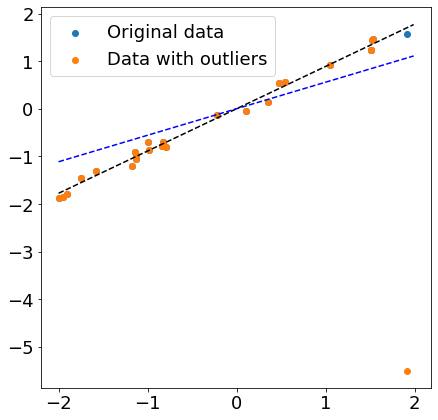

In [117]:
x = np.sort(4*(np.random.rand(25,1)-0.5),axis=0) # Random data from [-2,2]
b = 0.9*x + 0.1*np.random.randn(len(x),1)  # Line y = 0.9x with noise
atrue = np.linalg.lstsq(x,b,rcond=None)[0] # Least-squares slope (no outliers)
atrue = atrue.item(0)
plt.scatter(x,b, label = 'Original data')
xgrid = np.arange(-2,2,0.01)
plt.plot(xgrid,atrue*xgrid,'--',color='k')
b[-1] = -5.5
plt.scatter(x,b, label = 'Data with outliers')# Introduce outlier
acorrupt = np.linalg.lstsq(x,b,rcond=None)[0] # New slope
acorrupt = acorrupt.item(0)
xgrid = np.arange(-2,2,0.01)
plt.plot(xgrid,acorrupt*xgrid,'--',color='b')
plt.legend()
plt.show()

In [118]:
## L1 optimization to reject outlier
def L1_norm(a):
    return np.linalg.norm(a*x-b,ord=1)

a0 = acorrupt   # initialize to L2 solution
res = minimize(L1_norm, a0)
aL1 = res.x[0]  # aL1 is robust
print('Slope of original data:', atrue )
print('Slope of data with outliers:', acorrupt )
print('Slope of L1 optimization:', aL1 )

Slope of original data: 0.8884438988370899
Slope of data with outliers: 0.5571092627880604
Slope of L1 optimization: 0.8908945278479776


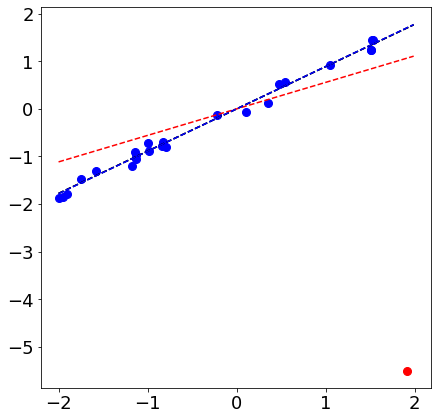

In [119]:
plt.plot(x[:-1],b[:-1],'o',color='b',ms=8) # Data
plt.plot(x[-1],b[-1],'o',color='r',ms=8)   # Outlier

xgrid = np.arange(-2,2,0.01)
plt.scatter(x,b, label = 'Original data')
plt.plot(xgrid,atrue*xgrid,'--',color='k')
plt.plot(xgrid,atrue*xgrid,'--',color='k')    # L2 fit (no outlier)
plt.plot(xgrid,acorrupt*xgrid,'--',color='r') # L2 fit (outlier)
plt.plot(xgrid,aL1*xgrid,'--',color='b')      # L1 fit

plt.show()

# LASSO regression

We consider an artificial data set consisting of 100 observations of
an outcome, arranged in a vector $b$

Each outcome in $b$ is given by a combination
of exactly 2 out of 10 candidate predictors, whose observations are arranged in the rows of
a matrix $A$

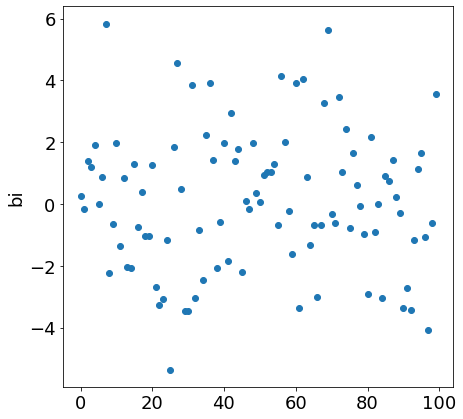

In [120]:
np.random.seed(45)
A = np.random.randn(100,10) # Matrix of possible predictors
x = np.array([0, 0, 1, 0, 0, 0, -1, 0, 0, 0]) #Two nonzero predictors
b = A @ x + 2*np.random.randn(100)
plt.scatter(range(100),b)
plt.ylabel('bi')
plt.show()

By using $l_2$ norm, the solution will be
$x_{l_2} = A^{+}b$

[-0.0805353   0.15522249  0.83389691 -0.11296064 -0.2454386   0.06315664
 -1.1619535  -0.03214151 -0.07181006  0.15234211]


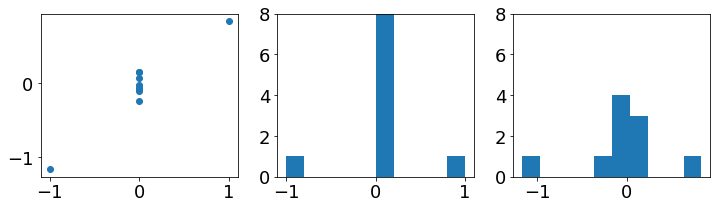

In [121]:
xL2 = np.linalg.pinv(A) @ b
print(xL2)
def plot_comparison(x1,x2):
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.scatter(x1,x2)
    plt.subplot(1,3,2)
    plt.hist(x1)
    plt.ylim(0,8)
    plt.subplot(1,3,3)
    plt.ylim(0,8)
    plt.hist(x2)
    plt.show()
plot_comparison(x,xL2)

### Built-in function for LASSO

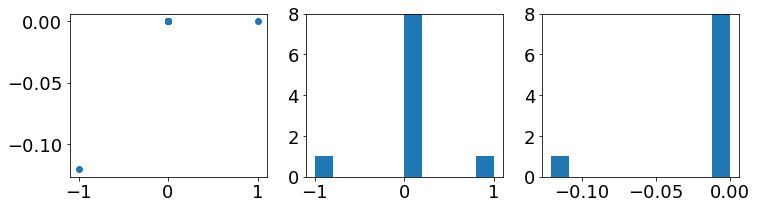

array([-0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.12042812, -0.        ,  0.        ,  0.        ])

In [122]:
lasso_model = linear_model.Lasso()
lasso_model.fit(A,b)
xL1 = lasso_model.coef_
plot_comparison(x,xL1)
xL1

### Built-in function for LASSO with cross-validation
Implementing the LASSO, with 10-fold cross-validation, is a single straightforward
command in Python: LassoCV
['from scikit-learn'](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)

Time for computing regularization path using LASSO: 0.13 sec
The best alpha is 0.2401


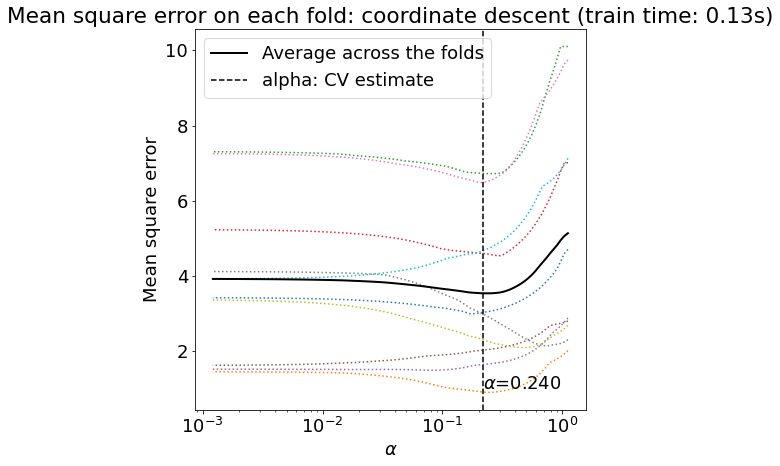

In [123]:
# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4
# Computing time
t1 = time.time()
reg = linear_model.LassoCV(cv=10).fit(A, b)
t_lasso_cv = time.time() - t1
# Compute paths
print("Time for computing regularization path using LASSO: {:.2f} sec".format(t_lasso_cv))
print('The best alpha is {:.4f}'.format(reg.alpha_))
# Display results
plt.figure()
plt.semilogx(reg.alphas_ + EPSILON, reg.mse_path_, ':')
plt.plot(reg.alphas_ + EPSILON, reg.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(reg.alpha_*0.9 + EPSILON, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.text(reg.alpha_*0.9,1,r'$\alpha$={:.3f}'.format(reg.alpha_))

plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.show()

[-0.     0.     0.593  0.    -0.     0.    -0.906 -0.    -0.     0.   ]


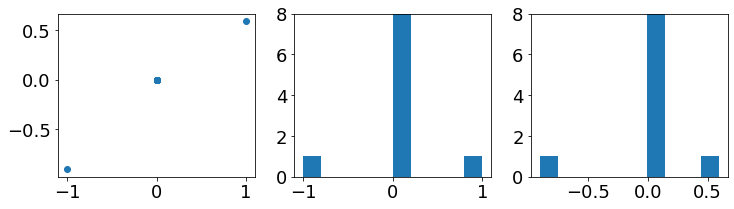

In [124]:
xL1CV = reg.coef_
print(np.round(xL1CV,3))
plot_comparison(x,xL1CV)

### Traditional way to find the best alpha

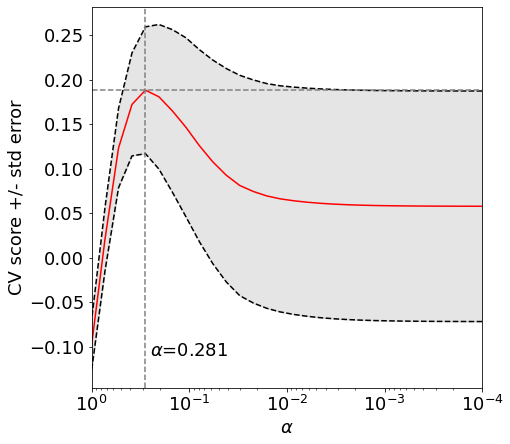

In [125]:
lasso = linear_model.Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, 0, 30) # from 10^-4 to 10^-0.5

tuned_parameters = [{'alpha': alphas}]

# find the best alpha or lambda
clf = model_selection.GridSearchCV(lasso, tuned_parameters, cv=10, refit=True)
clf.fit(A, b)
best_alpha = clf.best_params_['alpha']
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores,'r-')

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(10)

plt.semilogx(alphas, scores + std_error, 'k--')
plt.semilogx(alphas, scores - std_error, 'k--')
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.1,color='k')

plt.ylabel('CV score +/- std error')
plt.xlabel(r'$\alpha$')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.axvline(best_alpha,linestyle='--', color='.5')
plt.text(best_alpha*0.9,-0.11,r'$\alpha$={:.3f}'.format(best_alpha))
plt.xlim([alphas[-1], alphas[0]])

plt.show()

[-0.     0.     0.549  0.    -0.    -0.    -0.865 -0.    -0.     0.   ]


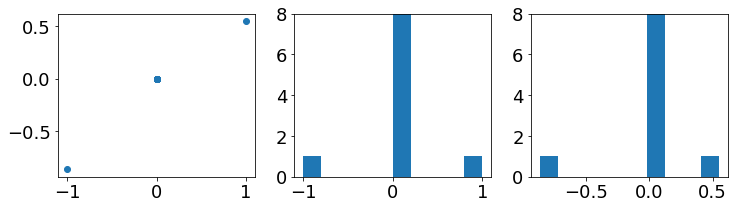

In [126]:
best_lasso = clf.best_estimator_
xL1CV2 = best_lasso.coef_
print(np.round(xL1CV2,3))
plot_comparison(x,xL1CV2)

In [127]:
print(clf.best_params_['alpha'])

0.2807216203941176


However, the regression values for these terms are not accurate, and so it may be necessary to de-bias the
LASSO by applying a final least-squares regression to the nonzero coefficients identified

In [128]:
def de_bias(coef):
    return np.linalg.pinv(A[:,np.abs(coef)>0]) @ b

for xl in [xL2,xL1,xL1CV,xL1CV2]:
    print(de_bias(xl))

[-0.0805353   0.15522249  0.83389691 -0.11296064 -0.2454386   0.06315664
 -1.1619535  -0.03214151 -0.07181006  0.15234211]
[-1.1631603]
[ 0.85232968 -1.14269825]
[ 0.85232968 -1.14269825]
